In [1]:
import pandas as pd
from datetime import timedelta
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', None)
pd.options.display.float_format ='{:,.0f}'.format
USDRUB = 61
EURRUB = 65


# предобработка
df = pd.read_csv('рейсы.csv')
df.info()
df['scheduled_departure'] = df.scheduled_departure.apply(lambda x:  datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))
df['scheduled_arrival'] = df.scheduled_arrival.apply(lambda x:  datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))
df['actual_departure'] = df.actual_departure.apply(lambda x:  datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))
df['actual_arrival'] = df.actual_arrival.apply(lambda x:  datetime.strptime(x, "%Y-%m-%dT%H:%M:%SZ"))
df['scheduled_duration'] = (df['scheduled_arrival']-df['scheduled_departure']).apply(lambda x: x.total_seconds()/60)
df['actual_duration'] = (df['actual_arrival']-df['actual_departure']).apply(lambda x: x.total_seconds()/60)
df['over_duration'] = (df['actual_duration'] - df['scheduled_duration']) 
df['delay_departure'] = (df['actual_departure'] - df['scheduled_departure']).apply(lambda x: x.total_seconds()/60)
df['month'] = df['actual_departure'].dt.month
df = df.drop(['scheduled_departure', 'scheduled_arrival'], axis=1)
df.fillna(value={'fare_conditions': '-', 'amount': 0}, inplace=True)      
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24282 entries, 0 to 24281
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flight_no            24282 non-null  object 
 1   scheduled_departure  24282 non-null  object 
 2   scheduled_arrival    24282 non-null  object 
 3   actual_departure     24282 non-null  object 
 4   actual_arrival       24282 non-null  object 
 5   departure_airport    24282 non-null  object 
 6   arrival_airport      24282 non-null  object 
 7   aircraft_code        24282 non-null  object 
 8   fare_conditions      24264 non-null  object 
 9   amount               24264 non-null  float64
 10  direction            24282 non-null  object 
dtypes: float64(1), object(10)
memory usage: 2.0+ MB


,flight_no,actual_departure,actual_arrival,departure_airport,arrival_airport,aircraft_code,fare_conditions,amount,direction,scheduled_duration,actual_duration,over_duration,delay_departure,month
0,PG0252,2017-02-06 10:11:00,2017-02-06 11:52:00,AAQ,SVO,733,Economy,"12,200",leave,100,101,1,6,2
1,PG0252,2017-02-06 10:11:00,2017-02-06 11:52:00,AAQ,SVO,733,Economy,"12,200",leave,100,101,1,6,2
2,PG0252,2017-02-06 10:11:00,2017-02-06 11:52:00,AAQ,SVO,733,Economy,"12,200",leave,100,101,1,6,2
3,PG0252,2017-02-06 10:11:00,2017-02-06 11:52:00,AAQ,SVO,733,Economy,"12,200",leave,100,101,1,6,2
4,PG0252,2017-02-06 10:11:00,2017-02-06 11:52:00,AAQ,SVO,733,Economy,"12,200",leave,100,101,1,6,2


In [2]:
#предварительный анализ рейсов    

groups = df.groupby(['flight_no'])
revenue = groups['amount'].sum()
departures = groups['actual_departure'].nunique() 
departures = departures.rename('departures')
num_seats = groups.size()
num_seats = num_seats.rename('num_seats')
aircraft = groups['aircraft_code'].first()
departure_airport = groups['departure_airport'].first()
arrival_airport = groups['arrival_airport'].first()
direction = groups['direction'].first()
scheduled_duration = groups['scheduled_duration'].mean()
actual_duration = groups['actual_duration'].mean()
over_duration = groups['over_duration'].mean()
delay_departure = groups['delay_departure'].mean()


df1 = pd.DataFrame(revenue).\
join(pd.DataFrame(departures), how='outer').\
join(pd.DataFrame(num_seats), how='outer').\
join(pd.DataFrame(aircraft), how='outer').\
join(pd.DataFrame(departure_airport), how='outer').\
join(pd.DataFrame(arrival_airport), how='outer').\
join(pd.DataFrame(direction), how='outer').\
join(pd.DataFrame(scheduled_duration), how='outer').\
join(pd.DataFrame(actual_duration), how='outer').\
join(pd.DataFrame(over_duration), how='outer').\
join(pd.DataFrame(delay_departure), how='outer')
print('предварительный анализ рейсов')
display(df1.T)


предварительный анализ рейсов


flight_no,PG0194,PG0195,PG0251,PG0252,PG0480,PG0481
amount,0,0,"99,174,800","96,912,000","41,915,700","42,876,900"
departures,9,9,59,59,59,59
num_seats,9,9,6836,6674,5321,5433
aircraft_code,733,733,733,733,SU9,SU9
departure_airport,AAQ,NOZ,SVO,AAQ,AAQ,EGO
arrival_airport,NOZ,AAQ,AAQ,SVO,EGO,AAQ
direction,leave,return,return,leave,leave,return
scheduled_duration,305,305,100,100,50,50
actual_duration,307,303,100,100,50,50
over_duration,2,-2,0,-0,0,0


In [3]:

'''
PG0194, PG0195 -  сборы по ним = 0. борта гоняли порожняком? Видимо некоммерческие рейсы, 
наверняка они выполнялись со служебной целью, их прибыльность нет смысла оценивать,
поэтому просто удалим их из датасета.


также выяснилось, что передержка бортов в воздухе сверх плана = 0 везде,
=> 'scheduled_duration', 'over_duration' можно тоже удалить.
'''


print('PG0194, PG0195 - некоммерческие рейсы, их анализировать не будем, удаляем')
df1.drop(['PG0194', 'PG0195'], axis=0, inplace=True)
df1.drop(['scheduled_duration', 'over_duration'], axis=1, inplace=True)
df = df[(df.flight_no!='PG0194') & (df.flight_no!='PG0195')]
display(df1)



PG0194, PG0195 - некоммерческие рейсы, их анализировать не будем, удаляем


,amount,departures,num_seats,aircraft_code,departure_airport,arrival_airport,direction,actual_duration,delay_departure
flight_no,,,,,,,,,
PG0251,"99,174,800",59,6836,733,SVO,AAQ,return,100,12
PG0252,"96,912,000",59,6674,733,AAQ,SVO,leave,100,6
PG0480,"41,915,700",59,5321,SU9,AAQ,EGO,leave,50,9
PG0481,"42,876,900",59,5433,SU9,EGO,AAQ,return,50,6


In [4]:
''' 
читаем ТТХ бортов: 
мест в салоне (шт), 
расход топлива (кг/ч), 
расходы на лизинг (руб в мес) 
https://zen.yandex.ru/media/air_alex/skolko-platiat-aviakompanii-v-den-za-lizing-samoletov-5c3f9a1ce0f88a00afe825e1
боинг - 486000 $ * 61 USDRUB / 1,02 / 1,02 / 1,02 (статья написана в 2020 => 3 года инфляции в долл. под 2%)

https://zen.yandex.ru/media/zhzhitel/skolko-stoit-samolet-sravnivaem-cenu-boinga-i-superdjeta-5ed5269909dce074858b7d01
суперджет - в производстве в 1,25 раз дороже => лизинг SU9 = лизинг боинга * 1,25


расходы на экипаж (руб в мес)

исходим из предположения, что экипаж рейсов больше кроме как между белгородом, анапой и москвой никуда не летал.
59 (туда) + 59 (обратно) = 118 вылетов
118 / 3 = 39 вылетов в месяц.
очень похоже на правду оптимальной загрузки борта.

'''
df_ac = pd.read_excel('ттх_бортов.xlsx',index_col=0)
df_ac.info()
display(df_ac)

<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 733 to 321
Data columns (total 5 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   aircraft_seats_available               9 non-null      int64  
 1   aircraft_fuel_flow_kg_per_hour         2 non-null      float64
 2   aircraft_leasing_costs_per_month       2 non-null      float64
 3   aircraft_land_service_costs_per_month  2 non-null      float64
 4   aircraft_crew_costs_per_month          2 non-null      float64
dtypes: float64(4), int64(1)
memory usage: 432.0+ bytes


,aircraft_seats_available,aircraft_fuel_flow_kg_per_hour,aircraft_leasing_costs_per_month,aircraft_land_service_costs_per_month,aircraft_crew_costs_per_month
aircraft_code,,,,,
733,130,"2,028","27,936,088","2,060,000","1,030,000"
SU9,97,"1,700","34,920,110","1,520,000","760,000"
CN1,12,nan,nan,nan,nan
320,140,nan,nan,nan,nan
CR2,50,nan,nan,nan,nan
773,402,nan,nan,nan,nan
763,222,nan,nan,nan,nan
319,116,nan,nan,nan,nan
321,170,nan,nan,nan,nan


In [5]:
'''
анализируем затраты, связанные с эксплуатацией бортов. исходим из предположения, что 

1) экипаж рейсов больше кроме как между белгородом, анапой и москвой никуда не летал.
59 (туда) + 59 (обратно) = 118 вылетов
118 / 3 = 39 вылетов в месяц.
очень похоже на правду оптимальной загрузки борта. 

=> нет иных маршрутов (extra_routes_per_vehicle) приходящихся на соответствующие строчкам борта.

=> 1 борт обслуживает рейс туда и обратно. т е количество маршрутов приходящихся на 1 борт (df1['num_routes']) = 2

=> на каждый рейс все месячные расходы (зарплаты, лизинг) сопоставим удельно (по принципу амортизации):

Половина зарплаты экипажа Боинга курсирующего между Москвой и Анапой приходится удельно на маршрут AAQ-SVO,
вторая половина зарплаты - на обратный рейс SVO-AAQ.

Аналогично для месячных затрат лизинга.

1 строчка таблицы df1 соответствует 1 маршруту. 

т.е. формула удельных костов для каждой строчки таблицы  
будет такова: 
cost = ( cost в мес   / количество маршрутов, обслуживаемых данным бортом. ) * 3 месяца

- это удельные расходы статьи затрат на все 59 вылетов конкретного рейса

количество маршрутов, обслуживаемых одним бортом = 2. (И для SU9 и 733).


'''
num_months = len(['дек','янв','февр'])
df_num_flights_per_period = pd.DataFrame(df1.groupby('aircraft_code').size()) # удельные затраты на лизинг соотнесенные на 1 рейс для каждого борта
df_num_flights_per_period.columns=['num_routes'] #количество маршрутов, выполняемых 1м бортом в датасете
df1 = df1.reset_index().set_index(['flight_no','aircraft_code'])
df1 = df1.join(df_num_flights_per_period)
df1 = df1.join(df_ac)


extra_routes_per_vehicle = 0*2
df1['costs_leasing'] = df1['aircraft_leasing_costs_per_month'] * num_months / (df1['num_routes'] + extra_routes_per_vehicle)
display(pd.DataFrame(df1['costs_leasing']))

df1['costs_crew'] = df1['aircraft_crew_costs_per_month'] * num_months / (df1['num_routes'] + extra_routes_per_vehicle)
display(pd.DataFrame(df1['costs_crew']))


'''

затраты на сервисные службы, ТО можно взять из предположения, что в соответствии с диагламмой затрат
https://zen.yandex.ru/media/air_alex/skolko-platiat-aviakompanii-v-den-za-lizing-samoletov-5c3f9a1ce0f88a00afe825e1
они в 2 раза превышают расходы на экипаж, это уже отражено в excel-таблице ттх бортов.xlsx. 
И тогда будут соотнесены на каждый маршрут по аналогичному "удельному" принципу.
#df1['costs_services'] = df1['aircraft_land_service_costs_per_month'] * num_months / (df1['num_routes'] + extra_routes_per_vehicle)

но найдена также информация, что затраты на наземное обслуживание и службы можно считать из расчета 800 руб на пассажира
https://smart-lab.ru/blog/506623.php по данным 2018г.
с учетом того, что нужна еще противообледенительная жидкость, возьмем для верности 900.

'''
df1['costs_services'] = 900 * df1['num_seats']
display(pd.DataFrame(df1['costs_services']))


'''
затраты на топливо = количество минут в воздухе * расход в минуту * стоимость 
минут_в_воздухе приводится к часам, стоимость приводится к цене за килограмм. расход номинирован в кг / час.
Удельная стоимость за ед. массы топлива - https://favt.gov.ru/dejatelnost-ajeroporty-i-ajerodromy-ceny-na-aviagsm/?id=7332
соотнесение по географии коэффициентов к москве взято оттуда.
Данные о стоимости в 2017 году найдены для SVO в яндексе, для других городов - помножены на соотв. коэффициент.
'''

def FindBestPrice(apt1, apt2):
    return min(df_fuel.loc[apt1]['price_per_1000kg_2017'], df_fuel.loc[apt2]['price_per_1000kg_2017'])

df_fuel = pd.read_excel('цена топлива.xlsx',index_col=0)[['price_per_1000kg_2017']]
df_fuel.info()
display(df_fuel)


df1['минут_в_воздухе'] = df1['actual_duration'] * df1['departures']
df1['best_fuel_price_per1000kg'] = df1.apply(lambda row: FindBestPrice(row['departure_airport'], row['arrival_airport']), axis=1)
df1['costs_fuel'] = (df1['best_fuel_price_per1000kg']/1000) * df1['aircraft_fuel_flow_kg_per_hour'] * (df1['минут_в_воздухе'] / 60)

display(pd.DataFrame(df1['costs_fuel']))



,,costs_leasing
flight_no,aircraft_code,
PG0251,733,"41,904,132"
PG0252,733,"41,904,132"
PG0480,SU9,"52,380,165"
PG0481,SU9,"52,380,165"


,,costs_crew
flight_no,aircraft_code,
PG0251,733,"1,545,000"
PG0252,733,"1,545,000"
PG0480,SU9,"1,140,000"
PG0481,SU9,"1,140,000"


,,costs_services
flight_no,aircraft_code,
PG0251,733,6152400
PG0252,733,6006600
PG0480,SU9,4788900
PG0481,SU9,4889700


<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, SVO to EGO
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   price_per_1000kg_2017  3 non-null      int64
dtypes: int64(1)
memory usage: 48.0+ bytes


,price_per_1000kg_2017
airport,
SVO,27000
AAQ,29100
EGO,31300


,,costs_fuel
flight_no,aircraft_code,
PG0251,733,"5,390,644"
PG0252,733,"5,374,228"
PG0480,SU9,"2,436,938"
PG0481,SU9,"2,433,931"


In [6]:
'''
калькуляция затрат на пайки питания
Исходим из данных со слов менторов, что в среднем, 
стоимость одного набора питания на пассажира 7-8$ для эконома, для бизнеса и первого класса 30-50$.
'''
food_costs = {'Business': 40*USDRUB, 'Comfort': 40*USDRUB, 'Economy': 8*USDRUB}



groups = df.groupby(['flight_no', 'fare_conditions'])
revenue = groups['amount'].sum()
departures = groups['actual_departure'].nunique()
departures = departures.rename('departures')
num_seats = groups.size()
num_seats = num_seats.rename('пассажиров_перевезено_всего')

df2 = pd.DataFrame(num_seats).\
join(pd.DataFrame(revenue), how='outer').\
join(pd.DataFrame(departures), how='outer')
df2['costs_food'] = df2.apply(lambda x: food_costs[x.name[1]]*x['пассажиров_перевезено_всего'], axis=1)
gr = df2.groupby('flight_no')
df_food = pd.DataFrame(gr['costs_food'].sum())
df1 = df1.join(df_food)
display(df2)
display(df1)

пассажиров_перевезено_всего     amount  departures  \
flight_no fare_conditions                                                       
PG0251    Business                                 631 23,094,600          59   
          Economy                                 6205 76,080,200          59   
PG0252    Business                                 620 22,692,000          59   
          Economy                                 6054 74,220,000          59   
PG0480    Business                                 653 12,341,700          59   
          Economy                                 4668 29,574,000          59   
PG0481    Business                                 673 12,719,700          59   
          Economy                                 4760 30,157,200          59   

                           costs_food  
flight_no fare_conditions              
PG0251    Business          1,539,640  
          Economy           3,028,040  
PG0252    Business          1,512,800  
          Economy           2,954,352  
PG0480    Business          1,593,320  
          Economy           2,277,984  
PG0481    Business          1,642,120  
          Economy           2,322,880

,,amount,departures,num_seats,departure_airport,arrival_airport,direction,actual_duration,delay_departure,num_routes,aircraft_seats_available,aircraft_fuel_flow_kg_per_hour,aircraft_leasing_costs_per_month,aircraft_land_service_costs_per_month,aircraft_crew_costs_per_month,costs_leasing,costs_crew,costs_services,минут_в_воздухе,best_fuel_price_per1000kg,costs_fuel,costs_food
flight_no,aircraft_code,,,,,,,,,,,,,,,,,,,,,
PG0251,733,"99,174,800",59,6836,SVO,AAQ,return,100,12,2,130,"2,028","27,936,088","2,060,000","1,030,000","41,904,132","1,545,000",6152400,"5,907",27000,"5,390,644","4,567,680"
PG0252,733,"96,912,000",59,6674,AAQ,SVO,leave,100,6,2,130,"2,028","27,936,088","2,060,000","1,030,000","41,904,132","1,545,000",6006600,"5,889",27000,"5,374,228","4,467,152"
PG0480,SU9,"41,915,700",59,5321,AAQ,EGO,leave,50,9,2,97,"1,700","34,920,110","1,520,000","760,000","52,380,165","1,140,000",4788900,"2,956",29100,"2,436,938","3,871,304"
PG0481,SU9,"42,876,900",59,5433,EGO,AAQ,return,50,6,2,97,"1,700","34,920,110","1,520,000","760,000","52,380,165","1,140,000",4889700,"2,952",29100,"2,433,931","3,965,000"


In [7]:

'''
подсчет финальных целевых и дополнительных весьма информативных метрик.
'''
df1['full_costs'] = df1['costs_leasing'] + df1['costs_fuel'] + df1['costs_crew'] + df1['costs_food'] + df1['costs_services']
df1['profit'] = df1['amount'] - df1['full_costs']
df1['прибыль в мес'] = df1['profit'] / num_months
df1['ROI'] = 100 * df1['profit'] / df1['full_costs']
df1['загрузка борта %'] = 100 * df1['num_seats'] / df1['departures'] / df1['aircraft_seats_available']
df1['cost per seat'] = df1['full_costs'] / df1['departures'] / df1['aircraft_seats_available']
display(df1.T)

flight_no,PG0251,PG0252,PG0480,PG0481
aircraft_code,733,733,SU9,SU9
amount,"99,174,800","96,912,000","41,915,700","42,876,900"
departures,59,59,59,59
num_seats,6836,6674,5321,5433
departure_airport,SVO,AAQ,AAQ,EGO
arrival_airport,AAQ,SVO,EGO,AAQ
direction,return,leave,leave,return
actual_duration,100,100,50,50
delay_departure,12,6,9,6
num_routes,2,2,2,2


In [8]:
'''
для анализа и понимания что не так с рейсом, необходимо взглянуть на его %-ю структуру издержек
'''
print('сруктура издержек')
df1['лизинг %'] = 100 * df1['costs_leasing'] / df1['full_costs']
df1['топливо %'] = 100 * df1['costs_fuel'] / df1['full_costs']
df1['экипаж %'] = 100 * df1['costs_crew'] / df1['full_costs']
df1['пайки %'] = 100 * df1['costs_food'] / df1['full_costs']
df1['службы %'] = 100 * df1['costs_services'] / df1['full_costs']


df_struct = df1[['лизинг %', 'топливо %', 'экипаж %', 'пайки %', 'службы %', 'загрузка борта %', 'прибыль в мес', 'cost per seat', 'ROI']].T
display(df_struct)
'''
Рейсы PG0480, PG0481 с суперджетом выглядят явными аутсайдерами.
И это, кстати, весьма сходится с данными о том, что Superjet100 - чертовски не выгодный самолет по сравнению с традиционными B737 и A320
https://zen.yandex.ru/media/zhzhitel/skolko-stoit-samolet-sravnivaem-cenu-boinga-i-superdjeta-5ed5269909dce074858b7d01
во всем виновата высокая себестоимость лайнера и как следствие, высокие затраты на лизинг.
Лизинг дороже, а пассажиров везет меньше, и это при более высоком коэффициенте относительной заполненности салона.
Себестоимость перевозки 1 пассажира (cost per seat) сильно выше в сравнении с B737.
Увы. Впрочем, не удивительно, почему государство доплачивает перевозчикам субсидии за эксплуатацию SJ.
'''

сруктура издержек


flight_no,PG0251,PG0252,PG0480,PG0481
aircraft_code,733,733,SU9,SU9
лизинг %,70,71,81,81
топливо %,9,9,4,4
экипаж %,3,3,2,2
пайки %,8,8,6,6
службы %,10,10,7,8
загрузка борта %,89,87,93,95
прибыль в мес,"13,204,981","12,538,296","-7,567,202","-7,310,632"
cost per seat,"7,765","7,731","11,291","11,324"
ROI,67,63,-35,-34


'\nРейсы PG0480, PG0481 с суперджетом выглядят явными аутсайдерами.\nИ это, кстати, весьма сходится с данными о том, что Superjet100 - чертовски не выгодный самолет по сравнению с традиционными B737 и A320\nhttps://zen.yandex.ru/media/zhzhitel/skolko-stoit-samolet-sravnivaem-cenu-boinga-i-superdjeta-5ed5269909dce074858b7d01\nво всем виновата высокая себестоимость лайнера и как следствие, высокие затраты на лизинг.\nЛизинг дороже, а пассажиров везет меньше, и это при более высоком коэффициенте относительной заполненности салона.\nСебестоимость перевозки 1 пассажира (cost per seat) сильно выше в сравнении с B737.\nУвы. Впрочем, не удивительно, почему государство доплачивает перевозчикам субсидии за эксплуатацию SJ.\n'

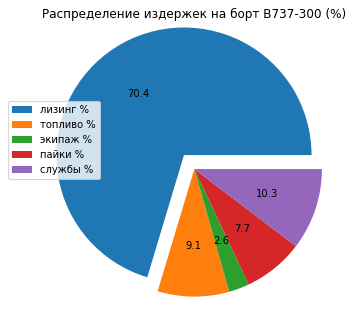

In [9]:
#визуализация структуры издержек
data_names = ['лизинг %', 'топливо %', 'экипаж %', 'пайки %',
              'службы %']
data_values = [df_struct.loc[data_names[0]]['PG0251']['733'], 
               df_struct.loc[data_names[1]]['PG0251']['733'], 
               df_struct.loc[data_names[2]]['PG0251']['733'], 
               df_struct.loc[data_names[3]]['PG0251']['733'], 
               df_struct.loc[data_names[4]]['PG0251']['733']]

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 9})

plt.title('Распределение издержек на борт B737-300 (%)')

xs = range(len(data_names))

plt.pie(
    data_values, autopct='%.1f', radius = 1.1,
    explode = [0.15] + [0 for _ in range(len(data_names) - 1)] )
plt.legend(
    bbox_to_anchor = (-0.16, 0.45, 0.25, 0.25),
    loc = 'lower left', labels = data_names )
fig.savefig('733.png')




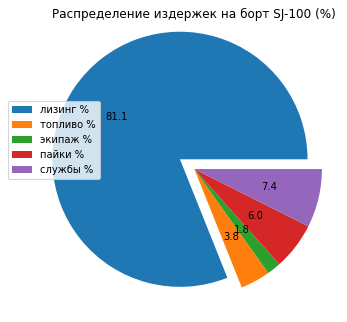

In [10]:
data_values = [df_struct.loc[data_names[0]]['PG0480']['SU9'], 
               df_struct.loc[data_names[1]]['PG0480']['SU9'], 
               df_struct.loc[data_names[2]]['PG0480']['SU9'], 
               df_struct.loc[data_names[3]]['PG0480']['SU9'], 
               df_struct.loc[data_names[4]]['PG0480']['SU9']]

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 9})

plt.title('Распределение издержек на борт SJ-100 (%)')

xs = range(len(data_names))

plt.pie(
    data_values, autopct='%.1f', radius = 1.1,
    explode = [0.15] + [0 for _ in range(len(data_names) - 1)] )
plt.legend(
    bbox_to_anchor = (-0.16, 0.45, 0.25, 0.25),
    loc = 'lower left', labels = data_names )
fig.savefig('SU9.png')



In [11]:
df1['себест. летного часа EUR'] = df1['full_costs'] / (df1['минут_в_воздухе'] / 60) / EURRUB
display(df1[['себест. летного часа EUR']].T)


'''
Сравнительная оценка 'себест. летного часа EUR' у меня в качестве валидации.
Она показывает, что наша модель недалеко от истины, если опираться на


https://flight-way.com/arenda-samoleta/stoimost/stoimost-charternogo-reysa/#:~:text=Boeing%2C%20Airbus%2C%20SSJ-100%20и%20CRJ-200,может%20обойтись%20около%2025000%20евро
стоимость 3-х часового перелета на Boeing 737 и Airbus 320 составляет около 45000 евро, а 2-х часовой перелет на SSJ-100 может обойтись около 25000 евро.

Мне кажется, что в нашей модели расходы на лизинг должны были получиться меньше, а на топливо выше. 
При таком уровне обилия "догадок" вместо точных данных достаточно неплохой результат. 
Полнота данных может улучшить расчет.

'''

flight_no,PG0251,PG0252,PG0480,PG0481
aircraft_code,733,733,SU9,SU9
себест. летного часа EUR,"9,308","9,295","20,181","20,265"


'\nСравнительная оценка \'себест. летного часа EUR\' у меня в качестве валидации.\nОна показывает, что наша модель недалеко от истины, если опираться на\n\n\nhttps://flight-way.com/arenda-samoleta/stoimost/stoimost-charternogo-reysa/#:~:text=Boeing%2C%20Airbus%2C%20SSJ-100%20и%20CRJ-200,может%20обойтись%20около%2025000%20евро\nстоимость 3-х часового перелета на Boeing 737 и Airbus 320 составляет около 45000 евро, а 2-х часовой перелет на SSJ-100 может обойтись около 25000 евро.\n\nМне кажется, что в нашей модели расходы на лизинг должны были получиться меньше, а на топливо выше. \nПри таком уровне обилия "догадок" вместо точных данных достаточно неплохой результат. \nПолнота данных может улучшить расчет.\n\n'